In [1]:
import torch
from models.models import *
from data_utils import *
import json
import argparse
from predict import *
from data_utils import *
from eval import *
from train import *

In [2]:
BASE_PATH = './Models'

CONFIG = {'hidden_dim': {'AWE': 300, 'LSTM':2048, 'BiLSTM':4096, 'BiLSTMpooling':4096},
		'vocab_path': './vocab.json',
		'device': 'cuda:4',
		'checkpoint': {'AWE': 9, 'LSTM': 13, 'BiLSTM': 12, 'BiLSTMpooling': 5},
		'model_path': {'AWE': os.path.join(BASE_PATH, 'awe'),
                        'LSTM': os.path.join(BASE_PATH, 'default'),
						'BiLSTM':os.path.join(BASE_PATH, 'bilstm'),
						'BiLSTMpooling':os.path.join(BASE_PATH, 'bilstmpooling')}}

Note the device key in the config. Change it according to your setup.

#### Define Encoder, Premise and Hypothesis in the next cell 

In [3]:
encoder = 'AWE'
premise = 'I am a boy.'
hypothesis = 'I am not a girl.'

In [4]:
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("The prediction is {}".format(pred_label))

The prediction is contradiction


#### In the following part, we will compare the different encoder types

In [3]:
val_loader, test_loader, vocab = get_data_loaders_()
vocab.build_vectors()

def Predict(encoder):
    ckp_path = os.path.join(CONFIG['model_path'][encoder], 'model_' + str(CONFIG['checkpoint'][encoder]) + '.pt')
    evaluator = Trainer.Initialize(encoder=encoder,
                                test_loader=test_loader,
                                vocab = vocab,
                                hidden_dim=CONFIG['hidden_dim'][encoder],
                                device=torch.device(CONFIG['device']),
                                checkpoint_path=ckp_path
                                )
    _, predictions, actual = evaluator.evaluate_on_test_data()
    
    return predictions, actual

Reading and Preparing dataset...:   0%|          | 15/9999 [00:00<01:07, 148.06it/s]

total pairs 9841, Vocabulary size 36547


Reading and Preparing dataset...: 100%|██████████| 9999/9999 [00:21<00:00, 468.90it/s]


total pairs 9823, Vocabulary size 36547
Embedding shape torch.Size([36547, 300])


In [4]:
pred_lstm, actual_lstm = Predict('LSTM')

Embedding shape torch.Size([36547, 300])


Evaluating on Test data: : 307it [00:07, 41.56it/s]


In [7]:
pred_bilstm, actual_bilstm = Predict('BiLSTM')

Embedding shape torch.Size([36547, 300])


Evaluating on Test data: : 307it [00:37,  8.10it/s]


In [8]:
pred_bilstmpooling, actual_bilstmpooling = Predict('BiLSTMpooling')

Embedding shape torch.Size([36547, 300])


Evaluating on Test data: : 307it [00:39,  7.84it/s]


In [9]:
pred_awe, actual_awe = Predict('AWE')

Evaluating on Test data: : 0it [00:00, ?it/s]

Embedding shape torch.Size([36547, 300])


Evaluating on Test data: : 307it [00:01, 183.16it/s]


In [10]:
from sklearn.metrics import confusion_matrix
conf_lstm = confusion_matrix(pred_lstm, actual_lstm)
conf_bilstm = confusion_matrix(pred_bilstm, actual_bilstm)
conf_bilstmpooling = confusion_matrix(pred_bilstmpooling, actual_bilstmpooling)
conf_awe = confusion_matrix(pred_awe, actual_awe)

Text(0.5, 1.0, 'Confusion Matrix for AWE')

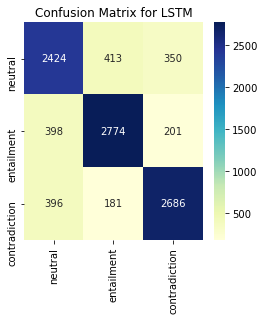

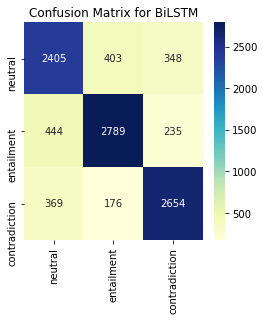

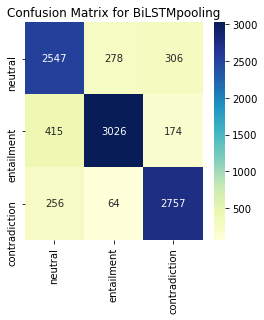

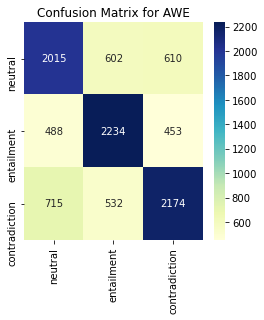

In [17]:
import seaborn as sn
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(conf_lstm, index = ['neutral', 'entailment', 'contradiction'],
                  columns = ['neutral', 'entailment', 'contradiction'])
plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix for LSTM')
df_cm = pd.DataFrame(conf_bilstm, index = ['neutral', 'entailment', 'contradiction'],
                  columns = ['neutral', 'entailment', 'contradiction'])
plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix for BiLSTM')
df_cm = pd.DataFrame(conf_bilstmpooling, index = ['neutral', 'entailment', 'contradiction'],
                  columns = ['neutral', 'entailment', 'contradiction'])
plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix for BiLSTMpooling')
df_cm = pd.DataFrame(conf_awe, index = ['neutral', 'entailment', 'contradiction'],
                  columns = ['neutral', 'entailment', 'contradiction'])
plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Confusion Matrix for AWE')

As can be observed from the confusion matrix, all the models are facing error on predicting "Neutral" label for the true label "Entailment", with AWE suffering the worst, and LSTM the least. Also, "Contradiction" label is also classified for many error cases to be neutral, with "AWE" doing it to a severe extent, and BiLSTM pooling to the lesser extent. Interestingly, BiLSTMpooling makes very less errors for classifying entailment as contradiction as opposed to the other models. This is a good case for superior performace of the BiLSTMpooling model, as this encoder is better than other models in sentence representation (as also evident from its performance on SentEval Transfer Tasks).

In the following cells, we will provide some examples to see the semantic representation ability of the models.

In [9]:
premise = "They look like the most efficient employee we have."
hypothesis = "They clearly are worst at their job"

print("Premise: {} Hypothesis: {}".format(premise, hypothesis))

encoder = "AWE"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "LSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTMpooling"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

Premise They look like the most efficient employee we have. Hypothesis They clearly are worst at their job
AWE: The prediction is neutral.
LSTM: The prediction is neutral.
BiLSTM: The prediction is contradiction.
BiLSTMpooling: The prediction is contradiction.


In [11]:
premise = "The manager of this company has gone bankrupt."
hypothesis = "This company has gone bankrupt."

print("Premise: {} Hypothesis: {}".format(premise, hypothesis))
encoder = "AWE"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "LSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTMpooling"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

Premise: The manager of this company has gone bankrupt. Hypothesis: This company has gone bankrupt.
AWE: The prediction is neutral.
LSTM: The prediction is entailment.
BiLSTM: The prediction is entailment.
BiLSTMpooling: The prediction is entailment.


In [12]:
premise = "It's a good day."
hypothesis = "It's not a good day."

print("Premise: {} Hypothesis: {}".format(premise, hypothesis))
encoder = "AWE"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "LSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTMpooling"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

Premise: It's a good day. Hypothesis: It's not a good day.
AWE: The prediction is neutral.
LSTM: The prediction is contradiction.
BiLSTM: The prediction is contradiction.
BiLSTMpooling: The prediction is contradiction.


In [13]:
premise = "It's a good day."
hypothesis = "It's not a good night."

print("Premise: {} Hypothesis: {}".format(premise, hypothesis))
encoder = "AWE"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "LSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTMpooling"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

Premise: It's a good day. Hypothesis: It's not a good night.
AWE: The prediction is neutral.
LSTM: The prediction is contradiction.
BiLSTM: The prediction is contradiction.
BiLSTMpooling: The prediction is contradiction.


In [14]:
premise = "He is a barber."
hypothesis = "He cuts hair."

print("Premise: {} Hypothesis: {}".format(premise, hypothesis))
encoder = "AWE"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "LSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTMpooling"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

Premise: He is a barber. Hypothesis: He cuts hair.
AWE: The prediction is contradiction.
LSTM: The prediction is neutral.
BiLSTM: The prediction is neutral.
BiLSTMpooling: The prediction is neutral.


In [16]:
premise = "The doctor treats the patient."
hypothesis = "She is a doctor, so she can treat you."

print("Premise: {} Hypothesis: {}".format(premise, hypothesis))
encoder = "AWE"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "LSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTM"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

encoder = "BiLSTMpooling"
predictor = Predictor.Initialize(encoder)
pred_label = predictor.predict(premise, hypothesis)

print("{}: The prediction is {}.".format(encoder, pred_label))

Premise: The doctor treats the patient. Hypothesis: She is a doctor, so she can treat you.
AWE: The prediction is neutral.
LSTM: The prediction is entailment.
BiLSTM: The prediction is entailment.
BiLSTMpooling: The prediction is entailment.


Interestingly, AWE for all the above examples is predicting "Neutral". This shows that AWE is the weaker model in semantic reasoning. While LSTM, BiLSTM, and BiLSTMpooling are able to give reasonable predictions. However, LSTM, BiLSTM, and BiLSTMpooling models are also doing shallow semantic reasoning. For example, in the last example, the predicted label should be "Neutral", however, the models predict "Contradiction" preseumably due to the mention of the antonym of the word "day". This kind of behavior can be seen for the pair: "Premise: I am a boy, Hypothesis: I am not a girl." This shows that these models are suffering with negation. The last two examplez shows that these models hints that these models are not doing semantic reasoning at all but relying on shallow signals (word match, word overlap, etc.). 

#### Results

|Method|dev|test| micro(SE)|macro(SE)|
|-----| -----|-----|-----|-----|
|AWE| 0.649|0.654|76.23|74.24|
|LSTM|0.808|0.802|77.45|73.77|
|BiLSTM|0.797|0.799|78.36 |75.24|
|BiLSTM with pooling|0.846|0.848|81.1|77.62|

Results on SNLI Task and SentEval Transfer Tasks for different models

|Method|STS14| MR|CR|MPQA|SUBJ|SST2|SST5|TREC|MRPC|SICKE|SICKR|
|-----| -----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|AWE|0.45|75.38|78.01|84.47|90.15|78.2|39.64|72.0|71.71|75.6|0.782|
|LSTM|0.56|71.58|77.43|84.96|86.57|76.83|38.46|72.2|72.64|83.28|0.85|
|BiLSTM with pooling|0.638|75.77|81.54|85.57|91.94|80.01|42.49|78.2|74.32|83.6|0.88|
|BiLSTM|0.546|71.77|77.8|85.07|88.23|76.88|41.31|74.0|73.51|83.78|0.862|

Results on Transfer Tasks for SentEval

The results above demonstrate that BiLSTM with pooling is performaing well compared to others in sentence representation learning.